In [1]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd

Using TensorFlow backend.


In [2]:
from keras.applications import vgg16

In [3]:
top_model = vgg16.VGG16(include_top = False,weights = 'imagenet',pooling = 'max', classes = 3)
for layer in top_model.layers[:-4]:
    layer.trainable = False

In [4]:
Train_Id = pd.read_csv("Train.csv")
print(Train_Id.head(5))
Test_Id = pd.read_csv("Test_Age.csv")

          ID   Class
0      0.jpg  MIDDLE
1      1.jpg     OLD
2    100.jpg  MIDDLE
3  10000.jpg  MIDDLE
4  10001.jpg   YOUNG


In [5]:
Train_Id["Class"].describe()

count      19906
unique         3
top       MIDDLE
freq       10804
Name: Class, dtype: object

In [6]:
print("Number of Training Examples:-",str(Train_Id.shape[0]))
print("Number of Test Examples:-",str(Test_Id.shape[0]))

Number of Training Examples:- 19906
Number of Test Examples:- 6636


In [7]:
Y = pd.get_dummies(Train_Id["Class"]).values
print(Y)

[[1 0 0]
 [0 1 0]
 [1 0 0]
 ...
 [1 0 0]
 [0 0 1]
 [0 0 1]]


In [8]:
import cv2
X = []
for i in range(Train_Id.shape[0]) :
    dir = str("Train/" + str(Train_Id.iloc[i,0])) 
    temp = cv2.imread(dir.strip(),1)
    t = cv2.resize(temp,(64,64))
    X.append(t)

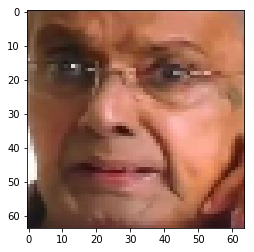

In [10]:
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(X[50], cv2.COLOR_BGR2RGB))
plt.show()

In [11]:
X = np.array(X,dtype = np.uint8)/255
print(X.shape)

(19906, 64, 64, 3)


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_csv, Y_train, Y_csv = train_test_split(X, Y, test_size=0.1,random_state = 5)

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras_preprocessing.image import ImageDataGenerator

In [14]:
datagen = ImageDataGenerator(horizontal_flip = True,rotation_range = 30, shear_range = 0.2)
datagen.fit(X_train,augment = True)
valgen = ImageDataGenerator()
valgen.fit(X_csv)

In [46]:
model = Sequential()
for l in top_model.layers : 
    model.add(l)
    model.add(BatchNormalization())
#model.add(Flatten())
model.add(Dense(256,activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(256,activation = 'relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(3,activation = tf.nn.softmax))

In [47]:
from keras.callbacks import ModelCheckpoint
filepath="age.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [48]:
model.compile(optimizer = 'adam',metrics = ["accuracy"],loss = "categorical_crossentropy")

In [51]:
model.fit_generator(datagen.flow(X_train,Y_train,batch_size=64),epochs = 20,steps_per_epoch = 17915//64,validation_data = valgen.flow(X_csv,Y_csv,batch_size = 64),validation_steps = 1991//64,callbacks = callbacks_list)

Epoch 1/20
279/279 [==============================] - 444s 2s/step - loss: 0.3309 - acc: 0.8690 - val_loss: 0.4188 - val_acc: 0.8367
Epoch 2/20
279/279 [==============================] - 443s 2s/step - loss: 0.2995 - acc: 0.8833 - val_loss: 0.4514 - val_acc: 0.8396
Epoch 3/20
279/279 [==============================] - 443s 2s/step - loss: 0.2700 - acc: 0.8952 - val_loss: 0.4232 - val_acc: 0.8490
Epoch 4/20
279/279 [==============================] - 443s 2s/step - loss: 0.2508 - acc: 0.9037 - val_loss: 0.3919 - val_acc: 0.8511
Epoch 5/20
279/279 [==============================] - 443s 2s/step - loss: 0.2229 - acc: 0.9137 - val_loss: 0.3855 - val_acc: 0.8599
Epoch 6/20
279/279 [==============================] - 443s 2s/step - loss: 0.2003 - acc: 0.9231 - val_loss: 0.4066 - val_acc: 0.8531
Epoch 7/20
279/279 [==============================] - 443s 2s/step - loss: 0.1790 - acc: 0.9322 - val_loss: 0.4354 - val_acc: 0.8526
Epoch 8/20
279/279 [==============================] - 443s 2s/step - 

In [52]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_27 (Batc (None, None, None, 3)     12        
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
batch_normalization_28 (Batc (None, None, None, 64)    256       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
batch_normalization_29 (Batc (None, None, None, 64)    256       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
batch_normalization_30 (Batc (None, None, None, 64)    256       
__________

In [53]:
model.load_weights("age.best.hdf5")

In [54]:
X_test = []
for j in range(Test_Id.shape[0]) :
    dir = str("Test/" + str(Test_Id.iloc[j,0])) 
    temp = cv2.imread(dir.strip(),1)
    X_test.append(temp)
resized = []
for i in X_test :
    t = cv2.resize(i,(64,64))
    resized.append(t)
X_test = np.array(resized,dtype = np.uint8)/255

In [55]:
Y_pred = model.predict(x = X_test)

In [56]:
Pred = np.argmax(Y_pred,axis = 1)
print(Pred.reshape((6636,1)))
print(Test_Id.shape)

[[0]
 [2]
 [0]
 ...
 [0]
 [0]
 [2]]
(6636, 1)


In [57]:
dic = {0: 'MIDDLE', 1: 'OLD', 2: 'YOUNG'}
Pred = [dic[x] for x in Pred]
sub = pd.DataFrame({'Class':Pred,'ID':Test_Id["ID"]})
sub.to_csv('Sub.csv',index=False)

In [67]:
at = model.evaluate(X_train,Y_train)[1]
acsv = model.evaluate(X_csv,Y_csv)[1]

1991/1991 [==============================] - 26s 13ms/step


In [68]:
print("Training set accuracy",at*100)
print("Cross validation set accuracy",acsv*100)

Training set accuracy 98.86128942559893
Cross validation set accuracy 87.34304369962857


Test set accuracy 88.26%